In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers datasets
!pip install --upgrade sympy
!pip install --upgrade datasets
!pip install evaluate
!pip install transformers
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 55.5 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uni

In [ ]:
import zipfile
import os

# ZIP 파일 경로
zip_path = "/content/drive/MyDrive/3-2 심층신경망개론/car_damage_data.zip"
output_dir = "/content/car_damage_data_v"  # ZIP 파일을 풀 디렉토리
os.makedirs(output_dir, exist_ok=True)

# ZIP 파일 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"ZIP 파일이 해제되었습니다: {output_dir}")

ZIP 파일이 해제되었습니다: /content/car_damage_data_v


In [ ]:
# Split Data Into train/valid/test
import os
import shutil
from sklearn.model_selection import train_test_split

# 경로 설정
base_dir = "/content/car_damage_data_v/car_damage_data/valid"
image_dir = "/content/car_damage_data_v/car_damage_data/valid/image"
label_dir = "/content/car_damage_data_v/car_damage_data/valid/label"
output_dir = "/content/Split_data"
os.makedirs(output_dir, exist_ok = True)

# 출력 폴더 생성
for split in ["train", "valid", "test"]:
    os.makedirs(os.path.join(output_dir, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, split, "labels"), exist_ok=True)

# 이미지와 라벨 파일 가져오기
images = sorted(os.listdir(image_dir))
labels = sorted(os.listdir(label_dir))

# 이미지와 라벨 파일 매칭
print(len(images), len(labels))
assert len(images) == len(labels), "이미지와 라벨의 개수가 일치하지 않습니다."
data_pairs = list(zip(images, labels))

# 데이터를 7:1.5:1.5로 나누기
train_pairs, temp_pairs = train_test_split(data_pairs, test_size=0.3, random_state=42)
valid_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42)

# 데이터 분배 함수
def copy_files(pairs, split):
    for image_file, label_file in pairs:
        # 파일 경로 정의
        src_image_path = os.path.join(image_dir, image_file)
        src_label_path = os.path.join(label_dir, label_file)
        dest_image_path = os.path.join(output_dir, split, "images", image_file)
        dest_label_path = os.path.join(output_dir, split, "labels", label_file)

        # 파일 복사
        shutil.copy(src_image_path, dest_image_path)
        shutil.copy(src_label_path, dest_label_path)

# 파일 복사
copy_files(train_pairs, "train")
copy_files(valid_pairs, "valid")
copy_files(test_pairs, "test")

print("데이터가 성공적으로 분할되었습니다!")

10089 10089
데이터가 성공적으로 분할되었습니다!


In [ ]:
import os
import json
from PIL import Image, ImageDraw
from tqdm import tqdm  # 진행 상황 표시

# 데이터셋의 상위 디렉토리와 출력 디렉토리 설정
dataset_dir = "/content/Split_data"
output_base_dir = "/content/data/masks"
os.makedirs(output_base_dir, exist_ok=True)

# 데이터셋의 train, valid, test 각각 처리
for split in ["train", "valid", "test"]:
    # JSON 파일이 있는 디렉토리
    json_dir = os.path.join(dataset_dir, split, "labels")
    if not os.path.exists(json_dir):
        print(f"{split} 디렉토리가 없습니다: {json_dir}")
        continue

    # 마스크 저장 디렉토리
    output_dir = os.path.join(output_base_dir, split)
    os.makedirs(output_dir, exist_ok=True)

    # JSON 디렉토리 순회
    for json_file in tqdm(os.listdir(json_dir), desc=f"Processing {split}"):
        if not json_file.endswith(".json"):
            continue  # JSON 파일만 처리

        # JSON 파일 경로
        json_path = os.path.join(json_dir, json_file)

        # JSON 데이터 로드
        with open(json_path, "r") as f:
            data = json.load(f)

        # 이미지 정보 가져오기
        image_info = data["images"]
        image_width, image_height = image_info["width"], image_info["height"]
        image_file = image_info["file_name"]

        # 빈 마스크 생성 (배경은 0으로 설정)
        mask = Image.new("L", (image_width, image_height), 0)  # "L"은 흑백 이미지를 의미
        draw = ImageDraw.Draw(mask)

        # 어노테이션 처리
        for ann in data["annotations"]:
            # "damage"가 있으면 1로 처리
            if "damage" in ann and ann["damage"] is not None:
                segmentation = ann["segmentation"][0][0]  # 다각형 좌표
                polygons = [tuple(point) for point in segmentation]  # (x, y) 튜플로 변환

                # "damage" 부분만 1로 표시
                draw.polygon(polygons, fill=1)  # damage 부분을 1로 채우기

        # 마스크 저장
        mask_output_path = os.path.join(output_dir, f"{os.path.splitext(image_file)[0]}_mask.png")
        mask.save(mask_output_path)

Processing test: 100%|██████████| 1514/1514 [00:09<00:00, 157.85it/s]


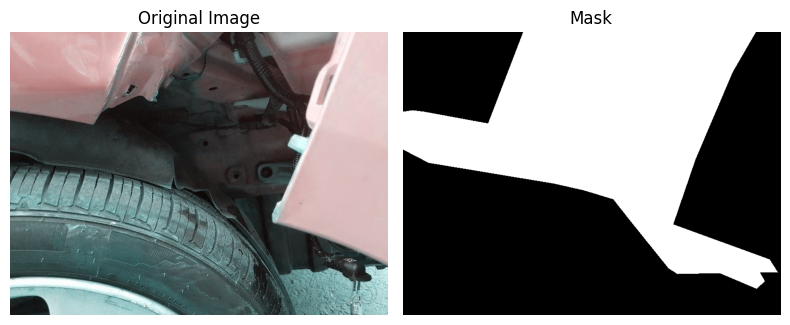

In [ ]:
# Mask Print
import matplotlib.pyplot as plt
import cv2

# 파일 경로 지정
imagefile = '/content/Split_data/train/images/0506239_as-3483186.jpg'
maskfile = '/content/data/masks/train/0506239_as-3483186_mask.png'

# 이미지와 마스크 불러오기
image = cv2.imread(imagefile)  # 컬러 이미지
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR -> RGB 변환
mask = cv2.imread(maskfile, cv2.IMREAD_GRAYSCALE)  # Grayscale 마스크

# 이미지와 마스크 시각화
plt.figure(figsize=(8, 8))

# 원본 이미지 표시
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')  # 축 숨기기

# 마스크 이미지 표시
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')  # Grayscale로 표시
plt.title("Mask")
plt.axis('off')  # 축 숨기기

plt.tight_layout()  # 레이아웃 조정
plt.show()

In [ ]:
import os
from datasets import Dataset
from transformers import TrainingArguments, Trainer
import torch
from PIL import Image
from transformers import MobileViTFeatureExtractor

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 경로 설정
train_images_dir = "/content/Split_data/train/images"
train_masks_dir = "/content/data/masks/train"


test_images_dir = "/content/Split_data/test/images"
test_masks_dir = "/content/data/masks/test"

# 배경 클래스 포함
label_mapping = {'Background': 0, 'Damaged': 1}

# id2label 및 label2id 생성
id2label = {v: k for k, v in label_mapping.items()}  # ID -> Label
label2id = {k: v for k, v in label_mapping.items()}  # Label -> ID

# 출력 확인
print("id2label:", id2label)
print("label2id:", label2id)

# 라벨 개수
num_labels = len(id2label)
print("Number of labels:", num_labels)

id2label: {0: 'Background', 1: 'Damaged'}
label2id: {'Background': 0, 'Damaged': 1}
Number of labels: 2


In [ ]:
#Feature Extractor 불러오기
model_name = "apple/deeplabv3-mobilevit-small"
processor = MobileViTFeatureExtractor.from_pretrained(
    model_name,
    id2label=id2label,  # 클래스 매핑 적용
    label2id=label2id   # 클래스 매핑 적용
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/mobilevit/feature_extraction_mobilevit.py:28: FutureWarning: The class MobileViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MobileViTImageProcessor instead.
  warnings.warn(


In [ ]:
# Load Dataset & Preprocessing

def load_data(images_dir, masks_dir):
    images = sorted(os.listdir(images_dir))
    masks = sorted(os.listdir(masks_dir))

    data = []
    for img_name, mask_name in zip(images, masks):
        image_path = os.path.join(images_dir, img_name)
        mask_path = os.path.join(masks_dir, mask_name)
        data.append({"image": image_path, "mask": mask_path})
    return data

train_data = load_data(train_images_dir, train_masks_dir)

test_data = load_data(test_images_dir, test_masks_dir)

# 데이터셋 준비
def preprocess(example):
    image = Image.open(example["image"]).convert("RGB").resize((512, 512))  # 512x512로 축소
    mask = Image.open(example["mask"]).resize((512, 512))
    encoding = processor(image, mask, return_tensors="pt")
    encoding = {k: v.squeeze(0).to(device) for k, v in encoding.items()}
    return encoding


train_dataset = Dataset.from_list(train_data).map(preprocess)

test_dataset = Dataset.from_list(test_data).map(preprocess)

Map:   0%|          | 0/7062 [00:00<?, ? examples/s]

Map:   0%|          | 0/1514 [00:00<?, ? examples/s]

In [ ]:
# Evaluation Metrics
import torch
from torch import nn
import evaluate

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    metrics = metric.compute(
        predictions=pred_labels,
        references=labels,
        num_labels=len(id2label),
        ignore_index=None,

    )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics

In [ ]:
from transformers import AutoModelForSemanticSegmentation

model = AutoModelForSemanticSegmentation.from_pretrained(
    "apple/deeplabv3-mobilevit-small").to(device)

config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/25.6M [00:00<?, ?B/s]

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total parameters: {total_params}')
print(f'Trainable parameters: {trainable_params}')

Total parameters: 6357941
Trainable parameters: 6357941


In [ ]:
from transformers import Trainer, TrainingArguments
import time



# 학습 파라미터 설정
training_args = TrainingArguments(
    output_dir="./mobilevit_deeplabv3_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    learning_rate=5e-5,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir="./logs",
)

# Trainer 객체 생성
trainer = Trainer(
    model= model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# 학습


trainer.train()


# 평가
trainer.evaluate()





/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Background,Accuracy Damaged,Iou Background,Iou Damaged
1,0.285300,0.259382,0.559690,0.605786,0.918962,0.989980,0.221593,0.917486,0.201894
2,0.206100,0.232590,0.588349,0.632064,0.925676,0.992258,0.271870,0.923921,0.252777


/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Epoch,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Background,Accuracy Damaged,Iou Background,Iou Damaged
1,0.285300,0.259382,0.559690,0.605786,0.918962,0.989980,0.221593,0.917486,0.201894
2,0.206100,0.232590,0.588349,0.632064,0.925676,0.992258,0.271870,0.923921,0.252777
3,0.198100,0.222841,0.604038,0.650063,0.927359,0.990241,0.309884,0.925279,0.282796


/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install safetensors
from safetensors.torch import load_file
from transformers import AutoModelForSemanticSegmentation
import torch
from PIL import Image

In [ ]:
!pip install safetensors
from safetensors.torch import load_file
from transformers import AutoModelForSemanticSegmentation, MobileViTFeatureExtractor
import torch
from PIL import Image

# 모델과 프로세서 불러오기
model_dir = '/content/drive/MyDrive/3-2 심층신경망개론/mobilevit+deeplabv3_pretrained'

# 모델과 가중치 자동 로드
model = AutoModelForSemanticSegmentation.from_pretrained(model_dir)
processor = MobileViTFeatureExtractor.from_pretrained("apple/deeplabv3-mobilevit-small")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Inference 준비
model.eval()  # 모델을 평가 모드로 설정 (Dropout, BatchNorm 등을 비활성화)
model.to(device)  # 모델을 GPU로 이동 (혹은 CPU)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/mobilevit/feature_extraction_mobilevit.py:28: FutureWarning: The class MobileViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MobileViTImageProcessor instead.
  warnings.warn(


MobileViTForSemanticSegmentation(
  (mobilevit): MobileViTModel(
    (conv_stem): MobileViTConvLayer(
      (convolution): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (normalization): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (encoder): MobileViTEncoder(
      (layer): ModuleList(
        (0): MobileViTMobileNetLayer(
          (layer): ModuleList(
            (0): MobileViTInvertedResidual(
              (expand_1x1): MobileViTConvLayer(
                (convolution): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (activation): SiLU()
              )
              (conv_3x3): MobileViTConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                (n

In [ ]:
# 이미지 불러오기
image = Image.open("/content/0541140_as-7855274.jpg").convert("RGB").resize((512, 512))  # 예시 이미지

# 이미지 전처리
inputs = processor(images=image, return_tensors="pt").to(device)

# Inference 수행
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # 모델의 출력 (예측된 logits)

# 출력 후 후처리 (예시: 예측된 클래스 레이블 얻기)
print(f"logit shape : {logits.shape}")
predictions = torch.argmax(logits, dim=1).squeeze(0)
print(f"after prediction and squeezing, segmap shape: {predictions.shape}")

logit shape : torch.Size([1, 21, 32, 32])
after prediction and squeezing, segmap shape: torch.Size([32, 32])


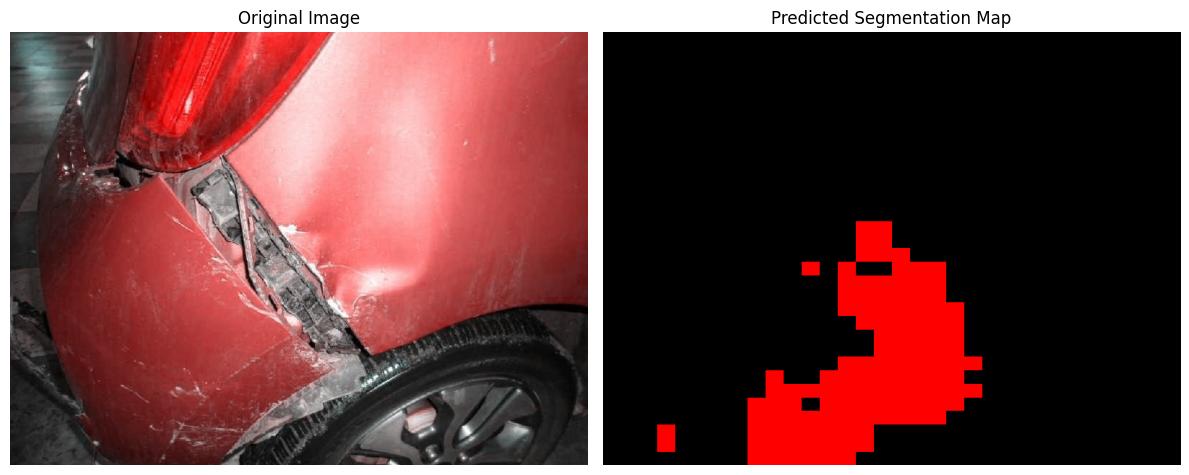

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # 이미지 로드를 위해 사용

# 클래스별 색상 정의
colors = [
    [0, 0, 0],      # Background
    [255, 0, 0]     # Damaged
]

# 예시: 원본 이미지 경로와 예측 맵 배열 (여기에 맞게 변경)
image_path = "/content/0541140_as-7855274.jpg"  # 원본 이미지 파일 경로

# 원본 이미지 로드
image = cv2.imread(image_path)  # OpenCV로 이미지 로드 (BGR 포맷)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RGB로 변환

# 세그멘테이션 맵을 색상으로 변환
colored_map = np.zeros((predictions.cpu().numpy().shape[0], predictions.cpu().numpy().shape[1], 3), dtype=np.uint8)
for class_id, color in enumerate(colors):
    colored_map[predictions.cpu().numpy() == class_id] = color

# 세그멘테이션 맵 크기를 원본 이미지 크기로 조정
colored_map_resized = cv2.resize(colored_map, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

# 이미지와 세그멘테이션 맵을 나란히 시각화
plt.figure(figsize=(12, 12))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# 세그멘테이션 맵
plt.subplot(1, 2, 2)
plt.imshow(colored_map_resized)
plt.title("Predicted Segmentation Map")
plt.axis("off")

plt.tight_layout()
plt.show()